In [4]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

^C


In [21]:
!pip install scikit-learn

     |████████████████████████████████| 26.7 MB 6.0 MB/s eta 0:00:01     |██████████████████████████▋     | 22.2 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 77.7 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 60.9 MB/s eta 0:00:01


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

In [2]:
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

In [3]:
resnet50 = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = True

2022-04-16 13:59:52.828143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:59:52.833917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:59:52.834059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:59:52.834695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [5]:
input = Input(shape=(224,224,3))
encoder = resnet50(input)
encoder_output = Conv2D(7, 1, activation="relu", padding="same")(encoder)

encoder_model = Model(inputs=[input], outputs=encoder_output)
#encoder_model.summary()

decoder_input = Input(shape=(7,7,7))
x = Conv2DTranspose(512, 3, 2, padding="same", activation="relu")(decoder_input)
x = Conv2DTranspose(256, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(128, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(64, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(3, 3, 2, padding="same", activation="sigmoid")(x)

decoder_model = Model(inputs=decoder_input, outputs=x)
#decoder_model.summary()



autoencoder_input = Input(shape=(224,224,3))
encoder_block = encoder_model(autoencoder_input)
decoder_block = decoder_model(encoder_block)
autoencoder_model = Model(inputs=autoencoder_input, outputs=decoder_block)
autoencoder_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 7, 7, 7)           23602055  
                                                                 
 model_4 (Functional)        (None, 224, 224, 3)       1583235   
                                                                 
Total params: 25,185,290
Trainable params: 25,132,170
Non-trainable params: 53,120
_________________________________________________________________


In [3]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

80
70


In [5]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, autoencoded):
    x = load_images(anchor)
    y = load_images(autoencoded)
    return (x, y)

def get_training_data(epoch_size=1024, training: bool=True):
    X = []
    Y = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = list(image_set.keys())

    for i in range(epoch_size):

        c = random.choice(available_classes)
        anchor = random.choice(image_set[c])

        X.append(f"{image_dir}/{c}/{anchor}")
        Y.append(f"{image_dir}/{c}/{anchor}")

    return (X, Y)

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    x = tf.data.Dataset.from_tensor_slices(data[0])
    y = tf.data.Dataset.from_tensor_slices(data[1])
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data


2022-04-17 12:30:16.944852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 12:30:16.950561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 12:30:16.950722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 12:30:16.951443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

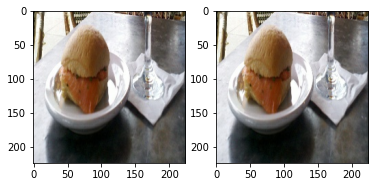

In [6]:
dasd = get_training_dataset(1024).take(1).as_numpy_iterator()

batch = next(dasd)
img1 = np.array(batch[0])
img2 = np.array(batch[1])

f, axarr = plt.pyplot.subplots(1,2)
axarr[0].imshow(img1)
axarr[1].imshow(img2)

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#autoencoder_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, metrics=METRICS, loss_weights=[10,80])
autoencoder_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/autoencoder

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/autoencoder/{0}'.format(current_time)
weight_dir = 'weights/autoencoder/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)

Reusing TensorBoard on port 6006 (pid 66254), started 1 day, 14:35:25 ago. (Use '!kill 66254' to kill it.)

In [12]:
class opencv_draw_callback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if batch % 100 == 0:
            data = get_training_dataset(1, False).as_numpy_iterator()
            data = next(data)
            pred = autoencoder_model.predict(data[0].reshape(-1,224,224,3))
            stack = np.hstack((data[0], pred[0]))
            cv2.imshow("inputoutput", stack)
            cv2.waitKey(1000)

opencv_callback = opencv_draw_callback()

In [13]:

train_data = get_training_dataset(4096*64)
train_data = train_data.batch(32)
train_data = train_data.prefetch(32)

val_data = get_training_dataset(4096, False)
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

# print(len(data[2]))
loss = autoencoder_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[
    tensorboard_callback, opencv_callback])
print(loss)


Epoch 1/20


2022-04-16 14:00:34.210835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-16 14:00:34.662722: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8192/8192 [==============================] - 2509s 305ms/step - loss: 0.5248 - tp: 13970935808.0000 - fp: 4080635.0000 - tn: 880711808.0000 - fn: 24604217344.0000 - accuracy: 0.0289 - precision: 0.9997 - recall: 0.3622 - auc: 0.9231 - prc: 0.9979 - val_loss: 0.5197 - val_tp: 208241984.0000 - val_fp: 64733.0000 - val_tn: 13872245.0000 - val_fn: 394383648.0000 - val_accuracy: 0.0288 - val_precision: 0.9997 - val_recall: 0.3456 - val_auc: 0.9201 - val_prc: 0.9978
Epoch 2/20
 386/8192 [>.............................] - ETA: 38:42 - loss: 0.5191 - tp: 665809600.0000 - fp: 136078.0000 - tn: 39491172.0000 - fn: 1153885184.0000 - accuracy: 0.0279 - precision: 0.9998 - recall: 0.3659 - auc: 0.9351 - prc: 0.9984

KeyboardInterrupt: 

In [14]:

encoder_model.save(os.path.join("weights/autoencoder", "autoencoder"),)


2022-04-16 14:44:23.602014: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/autoencoder/autoencoder/assets


In [7]:
encoder_model = tf.keras.models.load_model(os.path.join("weights/autoencoder", "autoencoder"))

In [23]:
data = get_training_dataset(20000, False).as_numpy_iterator()

X = []

for i,x in enumerate(data):
    preds = encoder_model.predict(np.array(x[0]).reshape(-1,224,224,3))
    X.append(preds)

In [24]:
flattened = [np.ndarray.flatten(y) for y in X]

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.mixture import GaussianMixture

In [25]:
full_components = len(flattened[1])
full_components

343

In [29]:
# pca = PCA(n_components=50)
# pca.fit(flattened)
kmeans = KMeans(init='k-means++', max_iter=500, n_clusters=90, n_init=5)
kmeans.fit(flattened)

#gm = GaussianMixture(n_components=90).fit(flattened)

#clustering_predictions = zip(kmeans.predict(flattened), flattened)

KMeans(max_iter=500, n_clusters=90, n_init=5)

In [28]:
import time
data = get_training_dataset(100, False).as_numpy_iterator()

for img, _ in data:
    pred = encoder_model.predict(img.reshape(-1,224,224,3))
    cluster = gm.predict([np.ndarray.flatten(pred)])
    print(cluster)
    if not os.path.exists(f"data/{str(cluster[0])}"):
        os.mkdir(f"data/{str(cluster[0])}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"data/{str(cluster[0])}/{str(time.time())}.jpg", img*255)
# for i,x in enumerate(X):
#     p = decoder_model.predict(x)
#     #cv2.imshow("decoder_out", p[0])
#     cluster = clustering.predict(np.ndarray.flatten(x).reshape(1,-1).astype(float))
#     #print(cluster)
#     #cv2.waitKey(1000)
#     cluster_output.append((cluster, p[0]))

[5]
[49]
[47]
[69]
[5]
[55]
[10]
[69]
[13]
[33]
[13]
[23]
[49]
[67]
[54]
[2]
[69]
[55]
[47]
[58]
[67]
[54]
[47]
[10]
[14]
[62]
[49]
[62]
[62]
[13]
[77]
[64]
[1]
[20]
[62]
[55]
[49]
[13]
[26]
[26]
[62]
[39]
[39]
[72]
[13]
[62]
[68]
[77]
[62]
[14]
[2]
[64]
[39]
[58]
[55]
[13]
[13]
[10]
[7]
[10]
[58]
[22]
[41]
[22]
[16]
[58]
[15]
[0]
[15]
[69]
[69]
[58]
[58]
[0]
[58]
[17]
[62]
[77]
[68]
[68]
[14]
[31]
[58]
[43]
[69]
[49]
[10]
[5]
[58]
[69]
[16]
[62]
[26]
[89]
[56]
[22]
[23]
[78]
[33]
[7]


In [15]:
cv2.destroyAllWindows()